# Inbalanced Classes
## In this lab, we are going to explore a case of imbalanced classes. 


Like we disussed in class, when we have noisy data, if we are not careful, we can end up fitting our model to the noise in the data and not the 'signal'-- the factors that actually determine the outcome. This is called overfitting, and results in good results in training, and in bad results when the model is applied to real data. Similarly, we could have a model that is too simplistic to accurately model the signal. This produces a model that doesnt work well (ever). 


### Note: before doing the first commit, make sure you don't include the large csv file, either by adding it to .gitignore, or by deleting it.

### First, download the data from: https://www.kaggle.com/ntnu-testimon/paysim1. Import the dataset and provide some discriptive statistics and plots. What do you think will be the important features in determining the outcome?
### Note: don't use the entire dataset, use a sample instead, with n=100000 elements, so your computer doesn't freeze.

In [1]:
# Your code here
import pandas as pd
import numpy as np
import random

#download the data from: https://www.kaggle.com/ntnu-testimon/paysim1
#save the csv file as Full_dataset_fraud on your working environment

##------------------------PREPARING NON FRAUD DATAFRAME-------------------------##

fraud = 8213
#we need to get 8213 non-fraud transactions

filename = 'Full_dataset_fraud.csv'
n = sum(1 for line in open(filename)) - 1 #number of records in file (excludes header)
s = 8500 #desired sample size
skip = sorted(random.sample(range(1,n+1),n-s)) #the 0-indexed header will not be included in the skip list
df = pd.read_csv(filename, skiprows=skip)

In [2]:
display(df.head())
display(df.info())
df.describe()
len_fraud = len(df[df['isFraud'] == 1])
df = df[df['isFraud'] != 1]



,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,4059.25,C200404000,4186.00,126.75,M1894758168,0.00,0.00,0,0
1,1,TRANSFER,483544.30,C593447952,0.00,0.00,C1286084959,876379.19,2107778.11,0,0
2,1,PAYMENT,3825.39,C1502668485,4094.00,268.61,M1457551880,0.00,0.00,0,0
3,1,DEBIT,3269.72,C1746257394,22906.25,19636.54,C793315160,25808.50,139915.18,0,0
4,1,TRANSFER,59531.87,C1886567481,0.00,0.00,C998351292,1968218.89,1015132.48,0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8500 entries, 0 to 8499
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   step            8500 non-null   int64  
 1   type            8500 non-null   object 
 2   amount          8500 non-null   float64
 3   nameOrig        8500 non-null   object 
 4   oldbalanceOrg   8500 non-null   float64
 5   newbalanceOrig  8500 non-null   float64
 6   nameDest        8500 non-null   object 
 7   oldbalanceDest  8500 non-null   float64
 8   newbalanceDest  8500 non-null   float64
 9   isFraud         8500 non-null   int64  
 10  isFlaggedFraud  8500 non-null   int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 630.9+ KB


None

In [3]:
z=len(df[df['isFraud'] == 0])

m = z-fraud
print(m)
np.random.seed(10)

remove_n = m
drop_indices = np.random.choice(df.index, remove_n, replace=False)
df_subset = df.drop(drop_indices)
df_subset=df_subset.reset_index(drop=True)

277


In [4]:
len(df_subset)

8213

In [5]:
df_nofraud = df_subset.copy()

In [6]:
df_nofraud

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,4059.25,C200404000,4186.00,126.75,M1894758168,0.00,0.00,0,0
1,1,TRANSFER,483544.30,C593447952,0.00,0.00,C1286084959,876379.19,2107778.11,0,0
2,1,PAYMENT,3825.39,C1502668485,4094.00,268.61,M1457551880,0.00,0.00,0,0
3,1,DEBIT,3269.72,C1746257394,22906.25,19636.54,C793315160,25808.50,139915.18,0,0
4,1,TRANSFER,59531.87,C1886567481,0.00,0.00,C998351292,1968218.89,1015132.48,0,0
...,...,...,...,...,...,...,...,...,...,...,...
8208,715,CASH_OUT,114040.84,C178654597,145140.00,31099.16,C97835552,79980.54,194021.38,0,0
8209,715,CASH_IN,216348.59,C1932402685,241926.00,458274.59,C217901482,102637.18,0.00,0,0
8210,716,CASH_IN,189879.35,C458179341,10377.00,200256.35,C1053799235,1274917.06,1085037.72,0,0
8211,717,CASH_OUT,198308.50,C342115143,215.00,0.00,C160187757,0.00,198308.50,0,0


In [7]:
df_nofraud.to_csv('nofraud_8213rec.csv')

In [8]:
##------------------------PREPARING FRAUD DATAFRAME-------------------------##

In [9]:
#We were getting around 99% and 1% of target = 0 & target = 1

#So I grabbed all the isFraud = 1 results and saved it on an excel, (I used an inbuilt import function in excel that allows us
#to create a filter on a future importing dataset)

#source: https://www.masterdataanalysis.com/ms-excel/analyzing-50-million-records-excel/

#It allows us to pre-query (filter the data set before importing it) pretty cool

#So I grabbed all the isFraud transactions = 8213 rows

#Then I balance my sample by grabbing 8500 random rows from the original file!
#Whenever we sample from the 6M rows we were getting very little isFraud = 1 rows, therefore we force them to appear
#for example from a 8500 sample we were getting: 10 fraud samples in 8500 which is very little

display(len_fraud)

#a wild fraudster appeared

10

In [10]:
df_fraud_only = pd.read_excel('fraud_trans_is_1.xlsx')
##------------------------PUTTING IT ALL TOGETHER-------------------------##
fraudsters = pd.concat([df_nofraud, df_fraud_only ])

In [11]:
fraudsters=fraudsters.reset_index(drop=True)

In [12]:
print(len(df_nofraud))
print(len(df_fraud_only))
fraudsters

8213
8213


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,4059.25,C200404000,4186.00,126.75,M1894758168,0.00,0.00,0,0
1,1,TRANSFER,483544.30,C593447952,0.00,0.00,C1286084959,876379.19,2107778.11,0,0
2,1,PAYMENT,3825.39,C1502668485,4094.00,268.61,M1457551880,0.00,0.00,0,0
3,1,DEBIT,3269.72,C1746257394,22906.25,19636.54,C793315160,25808.50,139915.18,0,0
4,1,TRANSFER,59531.87,C1886567481,0.00,0.00,C998351292,1968218.89,1015132.48,0,0
...,...,...,...,...,...,...,...,...,...,...,...
16421,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0
16422,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0
16423,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0
16424,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0


In [13]:
#Headers
#This is a sample of 1 row with headers explanation:

#1,PAYMENT,1060.31,C429214117,1089.0,28.69,M1591654462,0.0,0.0,0,0

#step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

#type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

#amount -
#amount of the transaction in local currency.

#nameOrig - customer who started the transaction

#oldbalanceOrg - initial balance before the transaction

#newbalanceOrig - new balance after the transaction

#nameDest - customer who is the recipient of the transaction

#oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

#newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

#isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

#isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

### What is the distribution of the outcome? 

In [14]:
# Your response here
#count_classes = pd.value_counts(df['isFraud'])
#count_classes.plot(kind = 'bar')

#WE were getting a much higher frequency of non fraud transaction ex 99% vs 1%, 
#therefore we can consider our dataframe imbalanced

#But we took care of it

In [15]:
fraudsters

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,4059.25,C200404000,4186.00,126.75,M1894758168,0.00,0.00,0,0
1,1,TRANSFER,483544.30,C593447952,0.00,0.00,C1286084959,876379.19,2107778.11,0,0
2,1,PAYMENT,3825.39,C1502668485,4094.00,268.61,M1457551880,0.00,0.00,0,0
3,1,DEBIT,3269.72,C1746257394,22906.25,19636.54,C793315160,25808.50,139915.18,0,0
4,1,TRANSFER,59531.87,C1886567481,0.00,0.00,C998351292,1968218.89,1015132.48,0,0
...,...,...,...,...,...,...,...,...,...,...,...
16421,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0
16422,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0
16423,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0
16424,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0


### Clean the dataset. How are you going to integrate the time variable? Do you think the step (integer) coding in which it is given is appropriate?

In [16]:
import seaborn as sns

In [17]:
# Your code here
fraudsters['nameOrig'].nunique() #We are dropping this column since it doesn't add any value (unique values = 16426)
#same applies to nameDest

#step we can drop it
#I know it does matter when we talk about time series  (continous variables)
#Not the case here

fraudsters.drop(columns=['nameOrig','step', 'nameDest'], inplace=True)



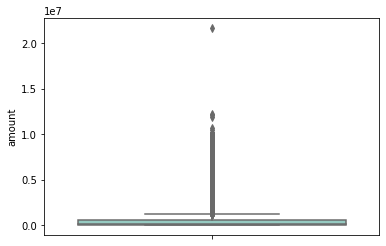

In [18]:
ax = sns.boxplot(y="amount", data=fraudsters, palette="Set3")
#We have huge outliers, lets standardize isntead of normalizing it

In [43]:
fraudsters_dummies.drop(columns='isFraud').corr()
#Are we double counting the weight of the variables with a higer correlation??
#newbalanceDest vs oldbalanceDest 0.938 corr 
#newbalanceOrig vs oldbalanceOrg 0.83 corr


,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFlaggedFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
amount,1.000000,0.639989,0.120174,0.004595,0.236138,0.067901,-0.125332,0.048729,-0.026230,-0.195780,0.197993
oldbalanceOrg,0.639989,1.000000,0.828488,0.006716,0.107468,0.062327,0.258395,-0.099272,-0.021132,-0.161344,0.065082
newbalanceOrig,0.120174,0.828488,1.000000,0.035212,0.005482,0.089009,0.454262,-0.177584,-0.010560,-0.082697,-0.051026
oldbalanceDest,0.004595,0.006716,0.035212,1.000000,0.938753,-0.006958,0.069844,0.097214,0.006590,-0.100113,-0.072524
newbalanceDest,0.236138,0.107468,0.005482,0.938753,1.000000,-0.009603,0.017895,0.195077,0.000007,-0.138173,-0.110980
isFlaggedFraud,0.067901,0.062327,0.089009,-0.006958,-0.009603,1.000000,-0.011019,-0.026915,-0.001859,-0.014030,0.048682
type_CASH_IN,-0.125332,0.258395,0.454262,0.069844,0.017895,-0.011019,1.000000,-0.304179,-0.021006,-0.158553,-0.226346
type_CASH_OUT,0.048729,-0.099272,-0.177584,0.097214,0.195077,-0.026915,-0.304179,1.000000,-0.051311,-0.387287,-0.552881
type_DEBIT,-0.026230,-0.021132,-0.010560,0.006590,0.000007,-0.001859,-0.021006,-0.051311,1.000000,-0.026746,-0.038182
type_PAYMENT,-0.195780,-0.161344,-0.082697,-0.100113,-0.138173,-0.014030,-0.158553,-0.387287,-0.026746,1.000000,-0.288189


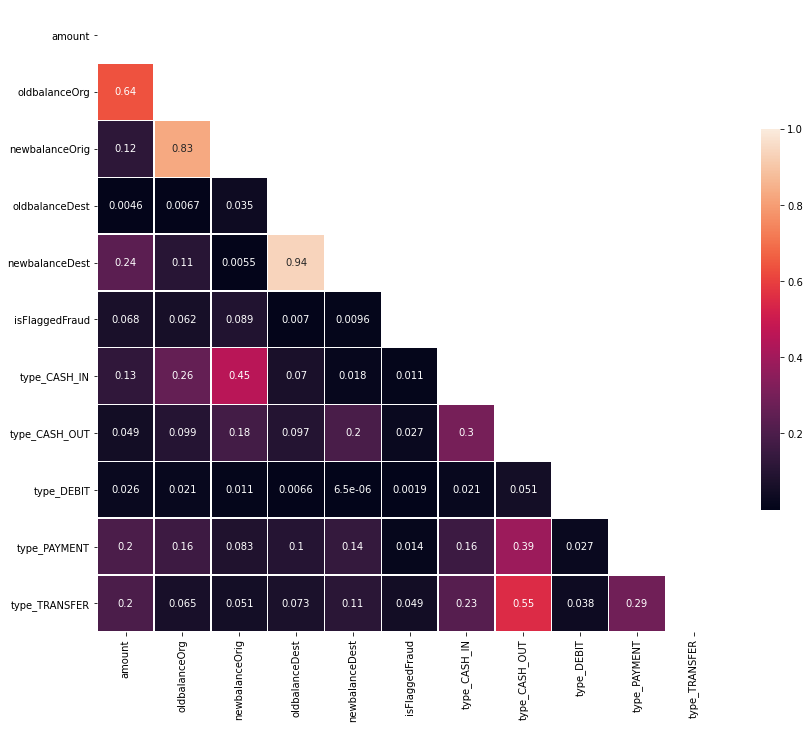

In [44]:
import matplotlib.pyplot as plt
import seaborn as sn

corr=np.abs(fraudsters_dummies.drop(columns='isFraud').corr())

#Set up mask for triangle representation
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(14, 14))
# Generate a custom diverging colormap
cmap = sn.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sn.heatmap(corr, mask=mask,  vmax=1,square=True, linewidths=.5, cbar_kws={"shrink": .5},annot = corr)

plt.show()

In [19]:
fraudsters['type'].unique()

array(['PAYMENT', 'TRANSFER', 'DEBIT', 'CASH_IN', 'CASH_OUT'],
      dtype=object)

In [20]:
fraudsters_dummies = pd.get_dummies(fraudsters)

In [21]:
fraudsters_dummies

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,4059.25,4186.00,126.75,0.00,0.00,0,0,0,0,0,1,0
1,483544.30,0.00,0.00,876379.19,2107778.11,0,0,0,0,0,0,1
2,3825.39,4094.00,268.61,0.00,0.00,0,0,0,0,0,1,0
3,3269.72,22906.25,19636.54,25808.50,139915.18,0,0,0,0,1,0,0
4,59531.87,0.00,0.00,1968218.89,1015132.48,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
16421,339682.13,339682.13,0.00,0.00,339682.13,1,0,0,1,0,0,0
16422,6311409.28,6311409.28,0.00,0.00,0.00,1,0,0,0,0,0,1
16423,6311409.28,6311409.28,0.00,68488.84,6379898.11,1,0,0,1,0,0,0
16424,850002.52,850002.52,0.00,0.00,0.00,1,0,0,0,0,0,1


In [22]:
features = list(fraudsters_dummies.columns)
features.remove('isFraud')

In [23]:
features

['amount',
 'oldbalanceOrg',
 'newbalanceOrig',
 'oldbalanceDest',
 'newbalanceDest',
 'isFlaggedFraud',
 'type_CASH_IN',
 'type_CASH_OUT',
 'type_DEBIT',
 'type_PAYMENT',
 'type_TRANSFER']

### Run a logisitc regression classifier and evaluate its accuracy.

In [24]:
#Do we need to normalize it? Just in case!

from sklearn import preprocessing



x = fraudsters_dummies.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
fraudsters_dummies_norm = pd.DataFrame(x_scaled, columns=fraudsters_dummies.columns)

In [25]:
#Do we need to standardize it? Just in case!

fraudsters_dummies_standard=pd.DataFrame(preprocessing.StandardScaler().fit_transform(fraudsters_dummies), columns=fraudsters_dummies.columns)

In [26]:
fraudsters_dummies_standard

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,-0.440682,-0.379190,-0.208912,-0.222818,-0.307527,-1.0,-0.031225,-0.352887,-0.861973,-0.059527,2.225670,-0.641413
1,-0.182534,-0.380462,-0.208962,0.006949,0.198963,-1.0,-0.031225,-0.352887,-0.861973,-0.059527,-0.449303,1.559057
2,-0.440808,-0.379218,-0.208856,-0.222818,-0.307527,-1.0,-0.031225,-0.352887,-0.861973,-0.059527,2.225670,-0.641413
3,-0.441107,-0.373499,-0.201277,-0.216051,-0.273906,-1.0,-0.031225,-0.352887,-0.861973,16.799015,-0.449303,-0.641413
4,-0.410816,-0.380462,-0.208962,0.293204,-0.063595,-1.0,-0.031225,-0.352887,-0.861973,-0.059527,-0.449303,1.559057
...,...,...,...,...,...,...,...,...,...,...,...,...
16421,-0.259987,-0.277205,-0.208962,-0.222818,-0.225903,1.0,-0.031225,-0.352887,1.160130,-0.059527,-0.449303,-0.641413
16422,2.955112,1.538094,-0.208962,-0.222818,-0.307527,1.0,-0.031225,-0.352887,-0.861973,-0.059527,-0.449303,1.559057
16423,2.955112,1.538094,-0.208962,-0.204861,1.225536,1.0,-0.031225,-0.352887,1.160130,-0.059527,-0.449303,-0.641413
16424,0.014763,-0.122077,-0.208962,-0.222818,-0.307527,1.0,-0.031225,-0.352887,-0.861973,-0.059527,-0.449303,1.559057


In [27]:
from sklearn.model_selection import train_test_split
y = fraudsters_dummies_standard['isFraud']
X = fraudsters_dummies_standard[features]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 1)

In [28]:
# Your code here
from sklearn.linear_model import LogisticRegression

# initialize the model
model = LogisticRegression()
# training your model on the training datasets -> where the algorithm will learn
model = model.fit(X_train, y_train)

In [29]:
print("test data accuracy was ",model.score(X_test,y_test))
print("train data accuracy was ", model.score(X_train, y_train))

test data accuracy was  0.9286583881178476
train data accuracy was  0.9271856481857293


### Now pick a model of your choice and evaluate its accuracy.

In [30]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train, y_train)
y_predict = knn.predict(X_test)
knn.score(X_test, y_test)

0.9678597516435354

In [31]:
#------------ENSEMBLE-----------------#

In [32]:
# Your code here
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor(random_state=1)
tree.fit(X_train, y_train)
tree.score(X_test,y_test)

0.9649368112257602

In [33]:
from sklearn.ensemble import BaggingRegressor

bagging_reg = BaggingRegressor(
    DecisionTreeRegressor(max_depth=3), # depth 3 to force tree to be "weak"
    n_estimators=10, # 10 trees
    max_samples=100, # we limit each weaker tree to 100 datapoints
    random_state=1) # fixing random state because I want my examples to work and to look smart

bagging_reg.fit(X_train, y_train)
bagging_reg.score(X_test,y_test)

0.7935597239844502

In [34]:
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor(n_estimators=10, # same 10 trees
                               max_depth=3, # depth 3 to force tree to be "weak"
                               random_state=1) # fixing rand because I'm insecure and afraid you will judge me if I get a bad random selection that does not prove my point
forest.fit(X_train, y_train)
forest.score(X_test,y_test)

0.8492751444458456

In [35]:
from sklearn.ensemble import AdaBoostRegressor

ada_reg = AdaBoostRegressor(DecisionTreeRegressor(max_depth=5), # you can overfit a bit because you compensate afterwards
                            n_estimators=10, # same 10 trees. You usually use faaaar more estimators
                            random_state=1 # once a coward, always a coward
                            )
ada_reg.fit(X_train, y_train)
ada_reg.score(X_test,y_test)

0.8227412078314711

In [36]:
from sklearn.ensemble import AdaBoostRegressor

ada_reg = AdaBoostRegressor(DecisionTreeRegressor(max_depth=5),
                            n_estimators=100, # that's more like it
                            random_state=1 # once a coward, always a coward
                            )
ada_reg.fit(X_train, y_train)
ada_reg.score(X_test,y_test)

0.6384902936938812

In [37]:
# gradient boosting also focus more on where the trees get it wrong
# but prefers to control the error rather than getting the observation fully right
# it is really trying to just "correct" the preceeding tree
from sklearn.ensemble import GradientBoostingRegressor

gb_reg = GradientBoostingRegressor(max_depth=5, #gradient boosting always works with trees, no need to call the tree regressor
                                   n_estimators=100,
                                   random_state=1 # tastes like chicken
                                   )
gb_reg.fit(X_train, y_train)
gb_reg.score(X_test,y_test)

0.9752474664660802

In [38]:
#I am having trouble pip installing the package


# XGBoost is one of the best algorithms to work on tabular data
# This is not the only nor the best (IMO) implementation of XGB - for example this does not accept nans (lightXGB would, for example)


#import xgboost
#
#xgb_reg = xgboost.XGBRegressor()
#xgb_reg.fit(X_train, y_train)
#xgb_reg.score(X_test,y_test)

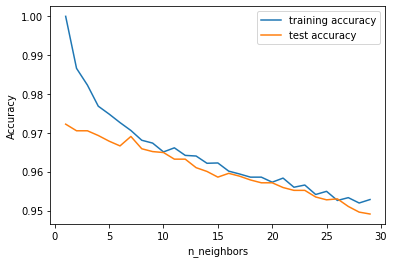

In [54]:
##----------------Lets try to hyperparameter tuning--------------------------##

import matplotlib.pyplot as plt

# hyerparameter tuning
training_accuracy = []
test_accuracy = []
# try n_neighbors from 1 to 30
neighbors_settings = range(1, 30)
for n_neighbors in neighbors_settings:
  # build the model
  clf = KNeighborsClassifier(n_neighbors=n_neighbors)
  #training the model
  clf.fit(X_train, y_train)
  # record training set accuracy
  training_accuracy.append(clf.score(X_train, y_train))
  # record generalization accuracy
  test_accuracy.append(clf.score(X_test, y_test))

plt.plot(neighbors_settings, training_accuracy, label="training accuracy")
plt.plot(neighbors_settings, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_neighbors")
plt.legend()

#It seems that the least n_neighbors we input it the better the accuracy score! Are we overfitting?

In [ ]:
#DECISION TREE CLASS

In [56]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(max_depth = 10)
model.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [57]:
#Trees are, unfortunately, overfitty
# relatively low performance on test
print("test data accuracy was ",model.score(X_test,y_test))
# 100% on training data
print("train data accuracy was ",model.score(X_train,y_train))

test data accuracy was  0.9892865838811785
train data accuracy was  0.9965094569364397


In [58]:
# why dont I repeat the process but choose the max_depth of the tree
max_depth = range(1,30)
test = []
train = []

for depth in max_depth:
    model = DecisionTreeClassifier(max_depth= depth)
    model.fit(X_train, y_train)
    test.append(model.score(X_test,y_test))
    train.append(model.score(X_train,y_train))

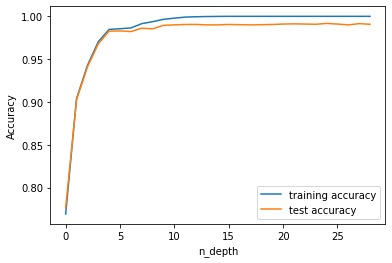

In [59]:
# we quickly see overfitting properties
plt.plot( train, label="training accuracy")
plt.plot( test, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_depth")
plt.legend()

In [61]:
# trees automaticaly give you "feature importance" based on how many times they split on a gien feature
model.feature_importances_

array([0.13993976, 0.36099793, 0.38917326, 0.00334501, 0.00929783,
       0.00097246, 0.        , 0.00094025, 0.00096153, 0.09299464,
       0.00137733])

In [67]:
# Support Vector Machine
from sklearn.svm import LinearSVC

model = LinearSVC()
model.fit(X_train, y_train)

print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

0.955597045214709
0.957146335524714


c:\users\xico2\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [70]:
from sklearn.model_selection import cross_validate

model = LinearSVC()
results = cross_validate(model,fraudsters_dummies_standard[features], fraudsters_dummies_standard['isFraud'], cv = 10)

c:\users\xico2\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\xico2\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\xico2\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\xico2\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\xico2\appdata\local\programs\python\python3

In [71]:
results['test_score'].mean()
results['test_score']

#Very consistent model

array([0.94948265, 0.96287279, 0.96591601, 0.95130858, 0.96348144,
       0.95556908, 0.95980512, 0.96163216, 0.95554202, 0.95797808])

### Which model worked better and how do you know?

In [39]:
# Your response here

# it seems that gradient boosting outputs the best accuracy prediction when 
#feeding new testing features that the model never saw
#Although since im still new at this I still struggle a little to detect if I am overfitting or not


### Note: before doing the first commit, make sure you don't include the large csv file, either by adding it to .gitignore, or by deleting it.

In [46]:
#regression tries

from sklearn.linear_model import LinearRegression

regr = LinearRegression()

# Train the linear regression
model = regr.fit(X_train, y_train)

# Score the model
model.score(X_test, y_test)

0.5168481770366551

In [47]:
from sklearn.linear_model import Ridge

# Create linear regression
regr = Ridge(alpha=1.0)

# Train the linear regression
model = regr.fit(X_train, y_train)

# Score the model
model.score(X_test, y_test)

0.5175061117093527

In [48]:
from sklearn.linear_model import Lasso

# Create linear regression
regr = Lasso(alpha=1.0)

# Train the linear regression
model = regr.fit(X_train, y_train)

# Score the model
model.score(X_test, y_test)

-5.5761264473153105e-05

In [49]:
from sklearn.tree import DecisionTreeRegressor

# Create decision tree classifer object
regr = DecisionTreeRegressor()

# Train regression tree model
model = regr.fit(X_train, y_train)

# Score the model  
regr.score(X_test, y_test)

0.9620148788279069

In [50]:
from sklearn.neighbors import KNeighborsRegressor

# create knn model
knnr = KNeighborsRegressor(n_neighbors = 3)

# Train the knn model
model = knnr.fit(X_train, y_train)

# Predict and score the model
y_pred = knnr.predict(X_test)
knnr.score(X_test, y_test)

0.9095283153849862

In [ ]:
#With the code below we can check how many false positives we are having

#We need to diminuish as possible the lower left corner value of the confusion_matrix

In [72]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

LR = LogisticRegression(max_iter=1000)
LR.fit(X_train, y_train)
LR.score(X_test, y_test)

pred = LR.predict(X_test)

print("precision: ",precision_score(y_test,pred))
print("recall: ",recall_score(y_test,pred))
print("f1: ",f1_score(y_test,pred))

precision:  0.9330400782013685
recall:  0.924455205811138
f1:  0.9287278034541474


In [73]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,pred)

array([[1905,  137],
       [ 156, 1909]], dtype=int64)

In [ ]:
##------It was missing the randomforestclassifier ---------------#

In [74]:
from sklearn.ensemble import RandomForestClassifier
forest_model = RandomForestClassifier(random_state=1) #not defining any hyperparameters
forest_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [75]:
forest_model.score(X_test,y_test)

0.9936693450206964

In [ ]:
#LETS USE GRID SEARCH TO FIND US THE BEST HYPERPARAMETER VALUES

In [76]:
# Grid Search goes through all combinations of hyperparameters
from sklearn.model_selection import GridSearchCV

# we need to define what we consider the "full list" of hyperparameters

# Number of trees in random forest
n_estimators = [10,100,500,1000]
# Mximum number of total leaves to consider
max_leaf_nodes = [15, 30, 40]
# Maximum number of levels in each tree
max_depth = [5,10]

In [77]:
# Create the  grid 
# this is a dictionary from hyperparameters to potential values
# the keys in this dictionary have to match the names of the hyperparameters in the documentation of the model
grid = {'n_estimators': n_estimators,
        'max_leaf_nodes': max_leaf_nodes,
        'max_depth': max_depth}

In [78]:
# Instantiate the grid search model object

# estimator -> model to optimize 
forest = RandomForestClassifier()
# param_grid -> state the dictionary of parameters to optimize
# cv = 5 -> number of cross validation folds <------ CV is REALLY important in grid search. Why?
grid_search = GridSearchCV(estimator = forest, param_grid = grid, cv = 5)

In [79]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train)

KeyboardInterrupt: 

In [ ]:
# and the winner is...
grid_search.best_params_

In [ ]:
# in grid search you are more likely to get really good results in your training set, even with CV
grid_search.best_score_

In [ ]:
grid_search.score(X_test, y_test)

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split <- a non-numeric parameter, no problem. Could also have been used in gridsearch
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None) #<- plus no cap
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [ ]:
# it would be a bit insane to go over all of these combinations
# random search to the rescue
from sklearn.model_selection import RandomizedSearchCV

# in random search you have to say how many iterations you want to get:
# n_ iter -> how many random combinations he will try

# n_jobs -> if you want sklearn to parallelize the process. Can also be used in grid search

random_search = RandomizedSearchCV(estimator = forest, param_distributions = random_grid, n_iter = 10, cv = 5, n_jobs = 10)

In [ ]:
random_search.fit(X_train,y_train)

In [ ]:
random_search.best_params_

In [ ]:
random_search.best_score_

In [ ]:
random_search.score(X_test, y_test)